## **Human-regularized RL** | Is there a trade-off between performance and human likeness? 

In [2]:
# Dependencies
import numpy as np
import glob
import pandas as pd
import re
import seaborn as sns
import warnings
import logging
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.sb3.reg_ppo import RegularizedPPO
from stable_baselines3.common.policies import ActorCriticPolicy
from networks.perm_eq_late_fusion import LateFusionNet, LateFusionPolicy 

from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.eval import EvaluatePolicy
from utils.policies import load_policy

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
os.environ["WANDB_NOTEBOOK_NAME"] = "trade_off_analysis.ipynb"

mpl.rcParams['lines.markersize'] = 12

### Configurations

In [3]:
MAX_FILES = 1000
DETERMINISTIC = True 
SINGLE_AGENT_MODE = True

In [4]:
# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.data_path = "../data_full/train/"
env_config.val_data_path = "../data_full/valid/"
env_config.num_files = MAX_FILES

# Convert to single agent env
if SINGLE_AGENT_MODE:
    env_config.max_num_vehicles = 1

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
# Make sure file order is fixed so that we evaluate on the same files used for training
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])[:MAX_FILES]

# Test
test_file_paths = glob.glob(f"{env_config.val_data_path}" + "/tfrecord*")
test_eval_files = sorted([os.path.basename(file) for file in test_file_paths])[:MAX_FILES]

# Behavioral cloning model path
BC_BASE_PATH = f"../models/il/S{MAX_FILES}"
HR_RL_BASE_PATH = f"../models/hr_rl/S{MAX_FILES}"

# Scenes on which to evaluate the models
hr_rl_policy_paths = glob.glob(f"{HR_RL_BASE_PATH}" + "/*.zip")
hr_rl_policy_names = [os.path.basename(file)[:-4] for file in hr_rl_policy_paths]
reg_weights = []
pattern = r'L(\d+\.\d+)_S'
for string in hr_rl_policy_names:
    match = re.search(pattern, string)
    if match:
        reg_weights.append(float(match.group(1)))
reg_weights

[0.01, 0.001, 0.05, 0.0, 0.5, 0.005, 0.2, 0.02]

### Logging

In [5]:
# Logging
logger = logging.getLogger()
logging.basicConfig(format="%(message)s")
logger.setLevel(LOGGING_LEVEL)

### 1. Evaluate **Behavioral Cloning (BC)** policy


In [6]:
# Load trained human reference policy
human_policy = load_policy(
    data_path=BC_BASE_PATH,
    file_name="human_policy_S1000_01_12_11_11", 
)

# Evaluate policy
evaluator = EvaluatePolicy(
    env_config=env_config, 
    exp_config=exp_config,
    policy=human_policy,
    eval_files=train_eval_files,
    log_to_wandb=False, 
    deterministic=DETERMINISTIC,
    reg_coef=0.0,
    return_trajectories=True,
)

df_il_res, df_il_trajs = evaluator._get_scores()
df_il_res['class'] = 'IL'

INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [01:53<00:00,  8.74it/s]


In [11]:
df_il_res.head()

,run_id,reg_coef,traffic_scene,agent_id,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,class
0,None,0.0,tfrecord-00001-of-01000_307.json,9,0.3375,0.662338,0.300000,3.112472,0.250596,0.0,0.0,0.0,IL
1,None,0.0,tfrecord-00004-of-01000_378.json,2,0.0625,1.607143,0.050000,10.309549,6.850359,1.0,0.0,0.0,IL
2,None,0.0,tfrecord-00005-of-01000_423.json,36,0.0000,2.181818,0.000000,13.693266,3.808041,1.0,0.0,0.0,IL
3,None,0.0,tfrecord-00007-of-01000_237.json,17,0.0000,3.300000,0.350000,10.583087,4.148146,0.0,1.0,0.0,IL
4,None,0.0,tfrecord-00012-of-01000_246.json,1,0.0375,2.079545,0.429545,20.777889,4.821891,0.0,0.0,1.0,IL


In [17]:
df_il_res['act_acc'].mean()

0.11904822705384503

In [8]:
df_il_res['act_acc'].mean()

0.09578313253012048

In [9]:
df_il_res['goal_rate'].mean()

0.4678714859437751

### 2. Evaluate **Human-regularized RL** policies

### 2.1 Train

In [10]:
env_config.data_path = "../data_full/train/"

df_hr_rl_train = pd.DataFrame()

for policy_name, reg_weight in zip(hr_rl_policy_names, reg_weights):
    
    SAVE_DIR = f"{HR_RL_BASE_PATH}/{policy_name}"

    # Load trained model object
    model = RegularizedPPO.load(SAVE_DIR);

    # Evaluate on scenes
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=model,
        eval_files=train_eval_files,
        log_to_wandb=False, 
        deterministic=DETERMINISTIC,
        reg_coef=reg_weight,
        return_trajectories=True,
    )
    
    df_rl_res, df_rl_trajs = evaluator._get_scores()
    df_hr_rl_train = pd.concat([df_hr_rl_train, df_rl_res])

df_hr_rl_train['Type'] = 'train'

INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [02:02<00:00,  8.10it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [01:58<00:00,  8.41it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [02:11<00:00,  7.57it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [01:59<00:00,  8.31it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [02:15<00:00,  7.33it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 996 files...
100%|██████████| 996/996 [01:58<00:00,  8.44it/s]
INFO:root:No regularization weight

### 2.2 Validation

In [11]:
# Single-agent setting
env_config.max_num_vehicles = 1
env_config.data_path = "../data_full/valid/"

df_hr_rl_test = pd.DataFrame()

for policy_name, reg_weight in zip(hr_rl_policy_names, reg_weights):
    
    SAVE_DIR = f"{HR_RL_BASE_PATH}/{policy_name}"

    # Load trained model object
    model = RegularizedPPO.load(SAVE_DIR);

    # Evaluate on scenes
    evaluator = EvaluatePolicy(
        env_config=env_config, 
        exp_config=exp_config,
        policy=model,
        eval_files=test_eval_files,
        log_to_wandb=False, 
        deterministic=DETERMINISTIC,
        reg_coef=reg_weight,
        return_trajectories=True,
    )
    
    df_rl_res, df_rl_trajs = evaluator._get_scores()
    df_hr_rl_test = pd.concat([df_hr_rl_test, df_rl_res])

df_hr_rl_test['Type'] = 'test'

INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:12<00:00,  8.19it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
100%|██████████| 99/99 [00:11<00:00,  8.47it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
100%|██████████| 99/99 [00:13<00:00,  7.48it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
100%|██████████| 99/99 [00:11<00:00,  8.40it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
100%|██████████| 99/99 [00:13<00:00,  7.50it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
100%|██████████| 99/99 [00:11<00:00,  8.44it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:
 Evaluating policy on 99 files...
100%|██████████| 99/99 [00:13<00:00,  7.49it/s]
INFO

In [9]:
# # # Load and merge 
# df_hr_rl_all = pd.concat([df_hr_rl_train, df_hr_rl_test])

# df_hr_rl_all.to_csv('../evaluation/results/df_hr_rl_sa_1000.csv')

In [26]:
df_hr_rl_all = pd.read_csv('../evaluation/results/df_hr_rl_sa_1000.csv')

In [27]:
human_like_metrics = ['act_acc', 'accel_val_mae', 'steer_val_mae', 'pos_rmse', 'speed_mae']
performance_metrics = ['goal_rate', 'veh_edge_cr', 'veh_veh_cr']

In [28]:
df_hr_rl_all.head()

,Unnamed: 0,run_id,reg_coef,traffic_scene,agent_id,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr,Type
0,0,NaN,0.01,tfrecord-00001-of-01000_307.json,9,0.0000,2.224138,0.675862,4.713227,3.126199,0.0,0.0,1.0,train
1,1,NaN,0.01,tfrecord-00004-of-01000_378.json,2,0.0250,3.125000,0.029167,9.875519,8.203099,1.0,0.0,0.0,train
2,2,NaN,0.01,tfrecord-00005-of-01000_423.json,36,0.0125,2.045455,0.000000,13.680396,4.080768,1.0,0.0,0.0,train
3,3,NaN,0.01,tfrecord-00007-of-01000_237.json,17,0.0375,3.807692,0.000000,10.519308,4.900133,1.0,0.0,0.0,train
4,4,NaN,0.01,tfrecord-00012-of-01000_246.json,1,0.0000,2.625000,0.350000,14.307607,0.686452,1.0,0.0,0.0,train


### Is there a trade-off between human likeness and performance? | **Pareto plots**

In [29]:
df_il_agg = df_il_res.groupby('class')[human_like_metrics + performance_metrics].mean()

df_il_agg['goal_rate'] = df_il_agg['goal_rate'] * 100
df_il_agg['veh_edge_cr'] = df_il_agg['veh_edge_cr'] * 100
df_il_agg['veh_veh_cr'] = df_il_agg['veh_veh_cr'] * 100
df_il_agg['act_acc'] = df_il_agg['act_acc'] * 100

mapping = {
    0.5: 'λ = 0.5',
    0.2: 'λ = 0.2',
    0.01: 'λ = 0.01',
    0.02: 'λ = 0.02',
    0.05: 'λ = 0.05',
    0.001: 'λ = 0.001',
    0.005: 'λ = 0.005',
    0.0: 'PPO',
    0.0075: 'λ = 0.0075'
}

# Replacing values in the 'reg_coef' column with the new names
df_hr_rl_all['reg_coef'] = df_hr_rl_all['reg_coef'].replace(mapping)
df_hr_rl_all.rename(columns={'reg_coef': 'Reg. weight', 'Type': 'Data'}, inplace=True)
df_hr_rl_agg = df_hr_rl_all.groupby(['Reg. weight', 'Data'])[human_like_metrics + performance_metrics].mean() 
df_hr_rl_agg['act_acc'] = df_hr_rl_agg['act_acc'] * 100
df_hr_rl_agg['goal_rate'] = df_hr_rl_agg['goal_rate'] * 100
df_hr_rl_agg['veh_edge_cr'] = df_hr_rl_agg['veh_edge_cr'] * 100
df_hr_rl_agg['veh_veh_cr'] = df_hr_rl_agg['veh_veh_cr'] * 100

In [30]:
df_hr_rl_agg

act_acc  accel_val_mae  steer_val_mae   pos_rmse  \
Reg. weight Data                                                        
PPO         test    2.436869       2.416266       0.305987  10.391844   
            train   2.589106       2.566038       0.302953  12.665245   
λ = 0.001   test    2.727273       2.639076       0.252565  10.049445   
            train   3.027108       2.735889       0.222808  12.734058   
λ = 0.005   test    3.522727       2.685715       0.181184  10.223570   
            train   3.634538       2.699631       0.206039  12.746062   
λ = 0.01    test    6.098485       2.156060       0.199286  10.204818   
            train   6.645331       2.262124       0.196646  12.791233   
λ = 0.02    test    7.095960       1.960907       0.172347  10.623013   
            train   7.444779       2.135661       0.166202  13.119946   
λ = 0.05    test   10.934343       1.634150       0.154046  10.716536   
            train  11.595131       1.715667       0.148710  13.160867   
λ = 0.2     test   12.348485       1.560929       0.148366  10.988130   
            train  12.863956       1.691237       0.126069  13.754708   
λ = 0.5     test   12.550505       1.570103       0.139970  10.844104   
            train  13.394829       1.604133       0.127779  13.812946   

                   speed_mae  goal_rate  veh_edge_cr  veh_veh_cr  
Reg. weight Data                                                  
PPO         test    4.437654  72.727273     4.040404   24.242424  
            train  36.081067  72.188755     4.618474   23.895582  
λ = 0.001   test    4.445176  71.717172    10.101010   20.202020  
            train  37.989319  70.682731     6.526104   24.196787  
λ = 0.005   test    4.459551  67.676768     6.060606   26.262626  
            train  37.252756  72.791165     5.020080   22.991968  
λ = 0.01    test    3.783635  75.757576     4.040404   21.212121  
            train  36.288350  76.606426     4.216867   18.975904  
λ = 0.02    test    3.553292  78.787879     7.070707   15.151515  
            train  36.559381  77.710843     5.522088   16.666667  
λ = 0.05    test    3.194525  70.707071     9.090909    9.090909  
            train  35.833024  72.991968     9.638554   11.546185  
λ = 0.2     test    3.469262  43.434343    19.191919   18.181818  
            train  37.504827  55.120482    15.662651   13.052209  
λ = 0.5     test    3.492851  40.404040    25.252525   13.131313  
            train  37.313796  47.590361    18.273092   12.951807

### Action accuracy

In [15]:
df_hr_rl_agg.loc['PPO', :]

,act_acc,accel_val_mae,steer_val_mae,pos_rmse,speed_mae,goal_rate,veh_edge_cr,veh_veh_cr
Data,,,,,,,,
test,2.436869,2.416266,0.305987,10.391844,4.437654,72.727273,4.040404,24.242424
train,2.589106,2.566038,0.302953,12.665245,36.081067,72.188755,4.618474,23.895582


In [16]:
df_hr_rl_agg

act_acc  accel_val_mae  steer_val_mae   pos_rmse  \
Reg. weight Data                                                        
PPO         test    2.436869       2.416266       0.305987  10.391844   
            train   2.589106       2.566038       0.302953  12.665245   
λ = 0.001   test    2.727273       2.639076       0.252565  10.049445   
            train   3.027108       2.735889       0.222808  12.734058   
λ = 0.005   test    3.522727       2.685715       0.181184  10.223570   
            train   3.634538       2.699631       0.206039  12.746062   
λ = 0.01    test    6.098485       2.156060       0.199286  10.204818   
            train   6.645331       2.262124       0.196646  12.791233   
λ = 0.02    test    7.095960       1.960907       0.172347  10.623013   
            train   7.444779       2.135661       0.166202  13.119946   
λ = 0.05    test   10.934343       1.634150       0.154046  10.716536   
            train  11.595131       1.715667       0.148710  13.160867   
λ = 0.2     test   12.348485       1.560929       0.148366  10.988130   
            train  12.863956       1.691237       0.126069  13.754708   
λ = 0.5     test   12.550505       1.570103       0.139970  10.844104   
            train  13.394829       1.604133       0.127779  13.812946   

                   speed_mae  goal_rate  veh_edge_cr  veh_veh_cr  
Reg. weight Data                                                  
PPO         test    4.437654  72.727273     4.040404   24.242424  
            train  36.081067  72.188755     4.618474   23.895582  
λ = 0.001   test    4.445176  71.717172    10.101010   20.202020  
            train  37.989319  70.682731     6.526104   24.196787  
λ = 0.005   test    4.459551  67.676768     6.060606   26.262626  
            train  37.252756  72.791165     5.020080   22.991968  
λ = 0.01    test    3.783635  75.757576     4.040404   21.212121  
            train  36.288350  76.606426     4.216867   18.975904  
λ = 0.02    test    3.553292  78.787879     7.070707   15.151515  
            train  36.559381  77.710843     5.522088   16.666667  
λ = 0.05    test    3.194525  70.707071     9.090909    9.090909  
            train  35.833024  72.991968     9.638554   11.546185  
λ = 0.2     test    3.469262  43.434343    19.191919   18.181818  
            train  37.504827  55.120482    15.662651   13.052209  
λ = 0.5     test    3.492851  40.404040    25.252525   13.131313  
            train  37.313796  47.590361    18.273092   12.951807

<Axes: xlabel='goal_rate', ylabel='veh_veh_cr'>

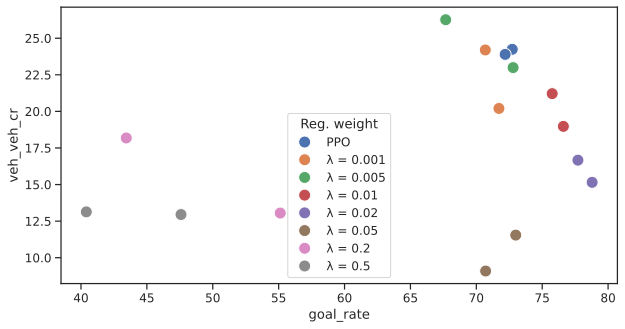

In [37]:
sns.scatterplot(x='goal_rate', y='veh_veh_cr', hue='Reg. weight', data=df_hr_rl_agg.reset_index())

<Axes: xlabel='Reg. weight', ylabel='veh_veh_cr'>

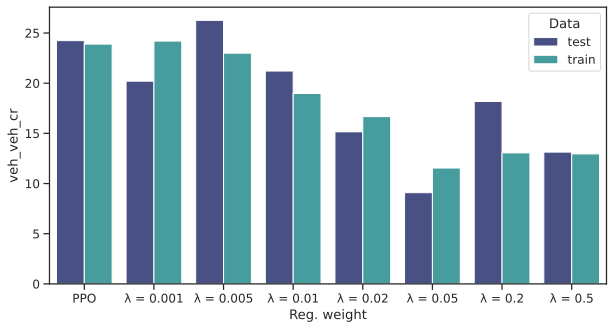

In [31]:
sns.barplot(x='Reg. weight', y='veh_veh_cr', hue='Data', data=df_hr_rl_agg.reset_index(), palette='mako')

<Axes: xlabel='Reg. weight', ylabel='veh_edge_cr'>

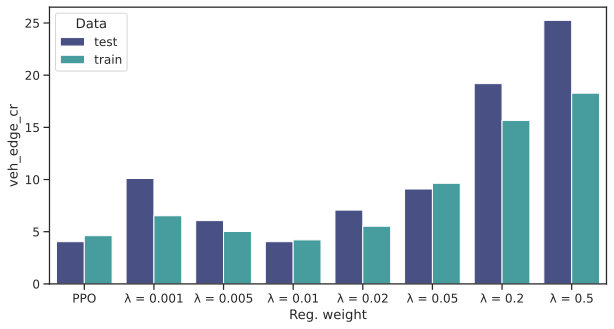

In [32]:
sns.barplot(x='Reg. weight', y='veh_edge_cr', hue='Data', data=df_hr_rl_agg.reset_index(), palette='mako')

<Axes: xlabel='Reg. weight', ylabel='goal_rate'>

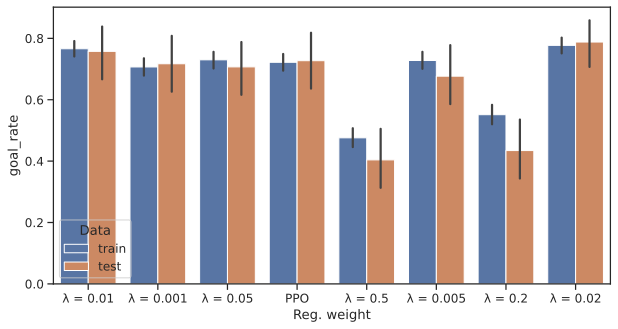

In [33]:
sns.barplot(x='Reg. weight', y='goal_rate', hue='Data', data=df_hr_rl_all.reset_index())

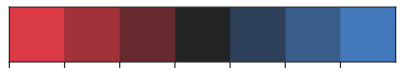

In [17]:
PALETTE = sns.diverging_palette(10, 250, s=75, l=50, n=7, center="dark")

sns.palplot(PALETTE)

In [18]:
# Settings
#PALETTE = 'coolwarm' # 'deep'
mpl.rcParams['lines.markersize'] = 12
MARKERS = ['^', 'P']
ALPHA = 0.6
PPO_COLOR = 'red'
IL_COLOR = 'dodgerblue'

# exclude PPO from df
df_hr_ppo = df_hr_rl_agg.loc[df_hr_rl_agg.index.get_level_values('Reg. weight') != 'PPO']

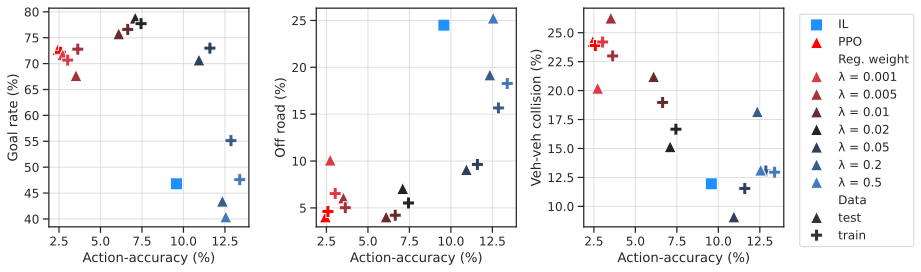

In [21]:
HL_METRIC = 'act_acc'

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='goal_rate', marker='s', label='IL', color=IL_COLOR, ax=axes[0], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='goal_rate', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[0], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='goal_rate', palette=PALETTE, hue='Reg. weight', style='Data', markers=MARKERS, ax=axes[0], legend=False)

# Accuracy to off road
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_edge_cr', marker='s', label='IL', color=IL_COLOR,  ax=axes[1], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_edge_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[1], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_edge_cr', hue='Reg. weight', palette=PALETTE, style='Data',markers=MARKERS, ax=axes[1], legend=False)


# Accuracy to collision rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_veh_cr', marker='s', label='IL', ax=axes[2], color=IL_COLOR, )
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_veh_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[2], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_veh_cr', hue='Reg. weight', markers=MARKERS, style='Data', palette=PALETTE, ax=axes[2])

axes[0].grid(True, alpha=ALPHA) 
axes[1].grid(True, alpha=ALPHA) 
axes[2].grid(True, alpha=ALPHA) 
axes[2].legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, labelspacing=0.5)

axes[0].set_xlabel(f'{HL_METRIC}')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')

axes[0].set_xlabel('Action-accuracy (%)')
axes[1].set_xlabel('Action-accuracy (%)')
axes[2].set_xlabel('Action-accuracy (%)')
plt.tight_layout()

plt.savefig(f'../evaluation/figures/{MAX_FILES}_{HL_METRIC}_sa.pdf', bbox_inches="tight")

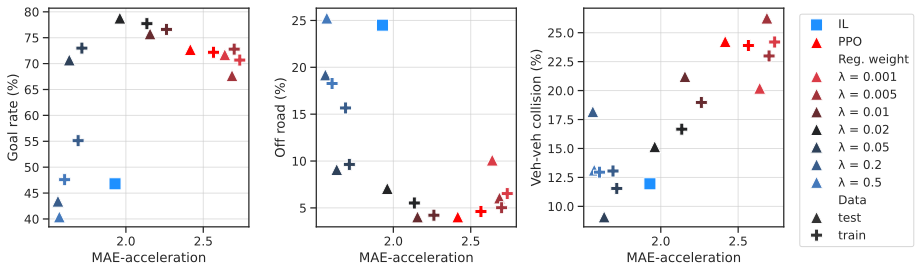

In [26]:
HL_METRIC = 'accel_val_mae'

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='goal_rate', marker='s', label='IL', color=IL_COLOR, ax=axes[0], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='goal_rate', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[0], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='goal_rate', palette=PALETTE, hue='Reg. weight', style='Data', markers=MARKERS, ax=axes[0], legend=False)

# Accuracy to off road
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_edge_cr', marker='s', label='IL', color=IL_COLOR,  ax=axes[1], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_edge_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[1], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_edge_cr', hue='Reg. weight', palette=PALETTE, style='Data',markers=MARKERS, ax=axes[1], legend=False)


# Accuracy to collision rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_veh_cr', marker='s', label='IL', ax=axes[2], color=IL_COLOR, )
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_veh_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[2], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_veh_cr', hue='Reg. weight', markers=MARKERS, style='Data', palette=PALETTE, ax=axes[2])

axes[0].grid(True, alpha=ALPHA) 
axes[1].grid(True, alpha=ALPHA) 
axes[2].grid(True, alpha=ALPHA) 
axes[2].legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, labelspacing=0.5)

axes[0].set_xlabel(f'{HL_METRIC}')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')


axes[0].set_xlabel('MAE-acceleration')
axes[1].set_xlabel('MAE-acceleration')
axes[2].set_xlabel('MAE-acceleration')
plt.tight_layout()

plt.savefig(f'../evaluation/figures/{MAX_FILES}_{HL_METRIC}.pdf', bbox_inches="tight")

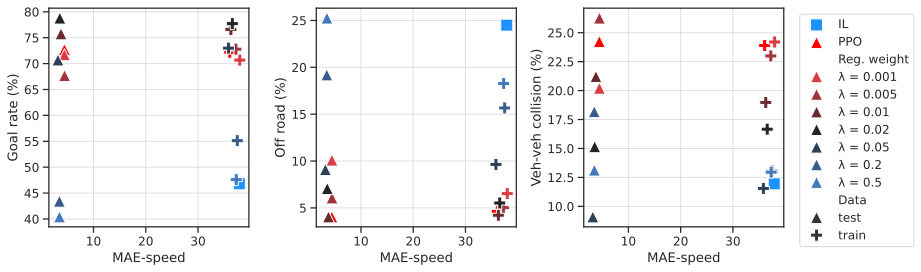

In [27]:
HL_METRIC = 'speed_mae'

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='goal_rate', marker='s', label='IL', color=IL_COLOR, ax=axes[0], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='goal_rate', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[0], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='goal_rate', palette=PALETTE, hue='Reg. weight', style='Data', markers=MARKERS, ax=axes[0], legend=False)

# Accuracy to off road
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_edge_cr', marker='s', label='IL', color=IL_COLOR,  ax=axes[1], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_edge_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[1], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_edge_cr', hue='Reg. weight', palette=PALETTE, style='Data',markers=MARKERS, ax=axes[1], legend=False)


# Accuracy to collision rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_veh_cr', marker='s', label='IL', ax=axes[2], color=IL_COLOR, )
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_veh_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[2], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_veh_cr', hue='Reg. weight', markers=MARKERS, style='Data', palette=PALETTE, ax=axes[2])

axes[0].grid(True, alpha=ALPHA) 
axes[1].grid(True, alpha=ALPHA) 
axes[2].grid(True, alpha=ALPHA) 
axes[2].legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, labelspacing=0.5)

axes[0].set_xlabel(f'{HL_METRIC}')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')


axes[0].set_xlabel('MAE-speed')
axes[1].set_xlabel('MAE-speed')
axes[2].set_xlabel('MAE-speed')
plt.tight_layout()

plt.savefig(f'../evaluation/figures/{MAX_FILES}_{HL_METRIC}.pdf', bbox_inches="tight")

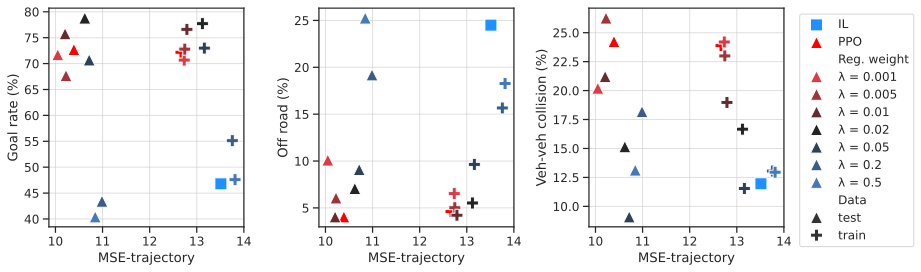

In [28]:
HL_METRIC = 'pos_rmse'

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Accuracy to goal rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='goal_rate', marker='s', label='IL', color=IL_COLOR, ax=axes[0], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='goal_rate', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[0], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='goal_rate', palette=PALETTE, hue='Reg. weight', style='Data', markers=MARKERS, ax=axes[0], legend=False)

# Accuracy to off road
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_edge_cr', marker='s', label='IL', color=IL_COLOR,  ax=axes[1], legend=False)
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_edge_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[1], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_edge_cr', hue='Reg. weight', palette=PALETTE, style='Data',markers=MARKERS, ax=axes[1], legend=False)


# Accuracy to collision rate
# IL
sns.scatterplot(data=df_il_agg, x=HL_METRIC, y='veh_veh_cr', marker='s', label='IL', ax=axes[2], color=IL_COLOR, )
# RL
sns.scatterplot(data=df_hr_rl_agg.loc['PPO', :], x=HL_METRIC, y='veh_veh_cr', palette=PALETTE, color=PPO_COLOR, style='Data', markers=MARKERS, ax=axes[2], label='PPO', legend=False)
# HR-RL
sns.scatterplot(data=df_hr_ppo, x=HL_METRIC, y='veh_veh_cr', hue='Reg. weight', markers=MARKERS, style='Data', palette=PALETTE, ax=axes[2])

axes[0].grid(True, alpha=ALPHA) 
axes[1].grid(True, alpha=ALPHA) 
axes[2].grid(True, alpha=ALPHA) 
axes[2].legend(
    bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, labelspacing=0.5)

axes[0].set_xlabel(f'{HL_METRIC}')
axes[0].set_ylabel('Goal rate (%)')
axes[1].set_ylabel('Off road (%)')
axes[2].set_ylabel('Veh-veh collision (%)')

axes[0].set_xlabel('MSE-trajectory')
axes[1].set_xlabel('MSE-trajectory')
axes[2].set_xlabel('MSE-trajectory')
plt.tight_layout()

plt.savefig(f'../evaluation/figures/{MAX_FILES}_{HL_METRIC}.pdf', bbox_inches="tight")